# CoGran examples

This notebooks shows examples of CoGran when used as a Python module.

In our examples we will re-apportion crime counts from the administrative unit "Bezirk" (of which Hamburg has 7) to "Stadtteil" (of which Hamburg has 99).

See the [readme](https://gitlab.com/g2lab/cogran-python/blob/master/README.md) for explanations on the methods themselves.


## Data used in this example:

### Source
- Geometries: http://suche.transparenz.hamburg.de/dataset/alkis-verwaltungsgrenzen-hamburg9 -> http://daten-hamburg.de/geographie_geologie_geobasisdaten/ALKIS_Verwaltungsgrenzen/ALKISVerwaltungsgrenzen_HH_2017-01-24.zip
    - The island of Neuwerk in the Elbe astuary was removed
    - Lizenz: Datenlizenz Deutschland Namensnennung 2.0
    - Namensnennung: Freie und Hansestadt Hamburg, Landesbetrieb Geoinformation und Vermessung

- Attribute `criminal cases`: http://suche.transparenz.hamburg.de/dataset/polizeiliche-kriminalstatistik-pks-2018 -> http://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/7c757888-7964-499b-860c-97117a1906a7/Akte_HmbTG_-_zu_veroeffentlichende_Dokumente.pdf
    - Lizenz: Datenlizenz Deutschland Namensnennung 2.0
    - Namensnennung: Freie und Hansestadt Hamburg

### Target
- Geometries: Same source as above
- Attribute `population`: http://suche.transparenz.hamburg.de/dataset/bevolkerungsdaten-zu-stadtteilen-in-hamburg7 -> https://geodienste.hamburg.de/HH_WFS_Statistik_Stadtteile_Bevoelkerung?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&typename=app:bevoelkerung_bev_abs_31122014
    - Lizenz: Datenlizenz Deutschland Namensnennung 2.0
    - Namensnennung: Statistisches Amt für Hamburg und Schleswig-Holstein

### Mask
- Geometries: http://suche.transparenz.hamburg.de/dataset/alkis-ausgewahlte-daten-hamburg4 -> http://daten-hamburg.de/geographie_geologie_geobasisdaten/ALKIS_Liegenschaftskarte/ALKIS_Liegenschaftskarte_ausgewaehlteDaten_HH_2018-07-07.zip
    - Lizenz: Datenlizenz Deutschland Namensnennung 2.0
    - Namensnennung: Freie und Hansestadt Hamburg, Landesbetrieb Geoinformation und Vermessung
- Attribute `fake percentage of total population`: These values were calculated and are not to be considered valid, see below. They are just used as an example.

# Imports and preparation

In [1]:
import fiona  # for file i/o

In [2]:
# for plotting
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import numpy as np

In [3]:
# to get some info from cogran
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
import cogran
from cogran.helpers import get_features, to_file

## Some *ugly* convenience functions for plotting
This notebook uses very basic plotting. For more sophisticated options check out PySAL's mapclassify and cartopy.

In [5]:
def add_choropleth(fig, ax, geometries, features, attribute, colormap="viridis"):
    """Add a (linearly colored, unclassed) PatchCollection to a figure."""

    patches = [PolygonPatch(polygon) for polygon in geometries]
    values = [f['properties'][attribute] for f in features]
    patchcollection = PatchCollection(patches, cmap=plt.get_cmap(colormap), edgecolor="None")
    patchcollection.set_array(np.array(values))

    colorbar = fig.colorbar(patchcollection, ax=ax)
    colorbar.ax.set_title(attribute)
    
    ax.add_collection(patchcollection)

In [6]:
def add_outlines(fig, ax, geometries):
    """Add an outlined PatchCollection to a figure."""

    patches = [PolygonPatch(polygon) for polygon in geometries]
    patchcollection = PatchCollection(patches, facecolor="None", edgecolor="grey")

    ax.add_collection(patchcollection)

In [7]:
def cogran_plot(attribute=None, source=None, target=None):
    """Horrible horrible HORRIBLE abuse of globals and stuff.
    
    TODO add mask?"""
    
    fig = plt.figure(figsize=(20,10))  # 20 10 just to make it big
    ax = plt.axes()

    if source == "choropleth":
        add_choropleth(fig, ax, source_geometries, source_features, attribute)
    if target == "choropleth":
        add_choropleth(fig, ax, target_geometries, target_features, attribute)

    if source == "outlines":
        add_outlines(fig, ax, source_geometries)
    if target == "outlines":
        add_outlines(fig, ax, target_geometries)

    ax.autoscale(True)
    ax.set_aspect('equal')
    plt.axis('off')  # we don't need those coordinate values
    plt.show()

# Areal Weighting

## Load source and target data

For reading in our geo data the wonderful Fiona library is used:

In [8]:
source_features, source_meta = get_features(
    "data/hamburg crime per bezirk.gpkg"
)

In [9]:
target_features, target_meta = get_features(
    "data/hamburg population per stadtteil.gpkg"
)

As the Fiona library loads the features as simple Python dictionaries, but we want to run highly-efficient geospatial analyses on their geometries, we create "sidecar" lists with Shapely geometries. The position of a geometry in such list corresponds with the position of its parent feature in the features lists.

In [10]:
source_geometries = cogran.make_geometries(source_features)
target_geometries = cogran.make_geometries(target_features)

To significantly speed up the determination of spatial relationships we generate a spatial index:

In [11]:
source_idx = cogran.generate_strtree(source_geometries)

Our source file has some attribute fields for which the features can have values:

In [12]:
source_meta['schema']['properties'].keys()

odict_keys(['name', 'criminal cases'])

The attribute we want to re-apportion is `"Alle_2012"`, the count of people per region.

In [13]:
attribute = "criminal cases"

Our data values are not relative (percentual) so we will use `relative = False`. cogran assumes that by default, but for the sake of this first example, let's be explicite.

Our source and target zones are covering the exact same total area, so we expect and want(!) the resulting sum of values to fit the sum in the source. cogran asserts that by default, but for the sake of this first example we will use `ignore_pycnophylactic = False`

### The source data

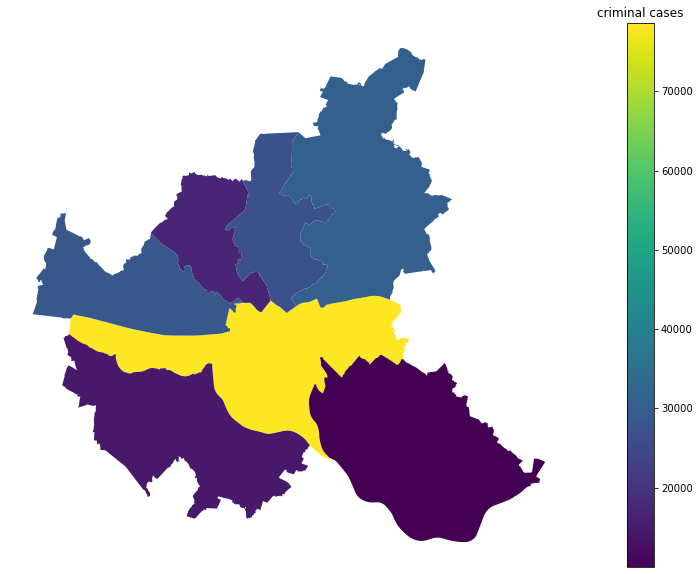

In [14]:
cogran_plot(attribute, source="choropleth")

### The target zones

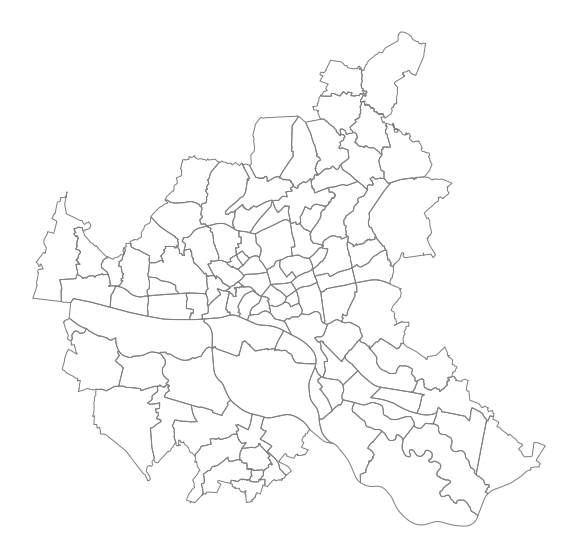

In [15]:
cogran_plot(attribute, target="outlines")

### Source data overlaid with target zones

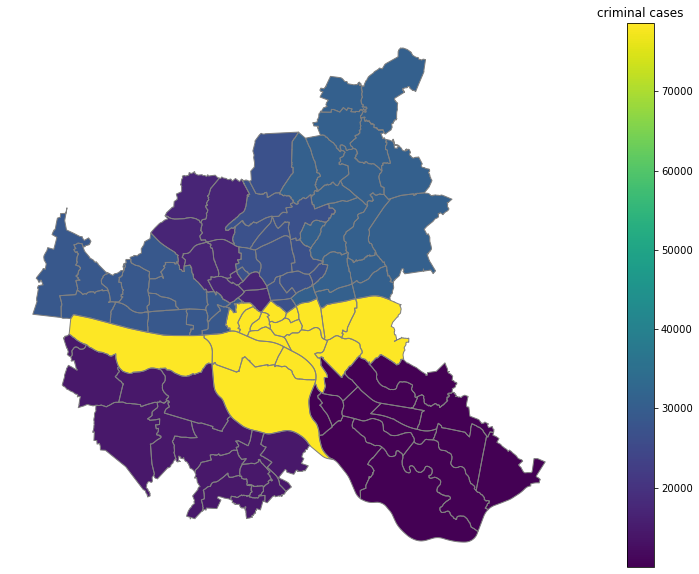

In [16]:
cogran_plot(attribute, source="choropleth", target="outlines")

## Cogran

In [17]:
target_features = cogran.areal_weighting(
    source_features=source_features,
    source_geometries=source_geometries,
    source_idx=source_idx,
    target_features=target_features,
    target_geometries=target_geometries,
    attribute=attribute,
    relative=False,
    ignore_pycnophylactic=False
)

INFO:root:Running Areal Weighting...
INFO:root:Processing target features...


INFO:root:Pycnophylactic property: 206689 (source) is within 0.001% of 206687.5468319628 (target).


### Resulting values for the target zones

In [18]:
cogran_plot(attribute, source="outlines", target="choropleth")

### Writing the results to a new file

CoGran supplies a convenient `to_file` function to write the results to a Fiona/GDAL-supported output file. This takes care of adding the new attribute field to the schema for you. The original attribute fields will be kept of course.

In [19]:
to_file(
    target_features,
    target_meta,
    attribute,
    "/tmp/aw.gpkg",
    "GPKG",
)

INFO:root:Writing features to /tmp/aw.gpkg...
INFO:root:Writing features... Done!


# Attribute Weighting

## Load source and target data

In [20]:
source_features, source_meta = get_features(
    "data/hamburg crime per bezirk.gpkg"
)

In [21]:
target_features, target_meta = get_features(
    "data/hamburg population per stadtteil.gpkg"
)

In [22]:
source_geometries = cogran.make_geometries(source_features)
target_geometries = cogran.make_geometries(target_features)

In [23]:
source_idx = cogran.generate_strtree(source_geometries)

## Cogran

In [24]:
target_features = cogran.attribute_weighting(
    source_features=source_features,
    source_geometries=source_geometries,
    source_idx=source_idx,
    target_features=target_features,
    target_geometries=target_geometries,
    attribute="criminal cases",
    weight="population"
)

INFO:root:Running Attribute Weighting...
INFO:root:Calculating target weight per source feature...


INFO:root:Processing target features...


INFO:root:Pycnophylactic property: 206689 (source) is within 0.001% of 206689.00000000006 (target).


### Source data overlaid with target zones

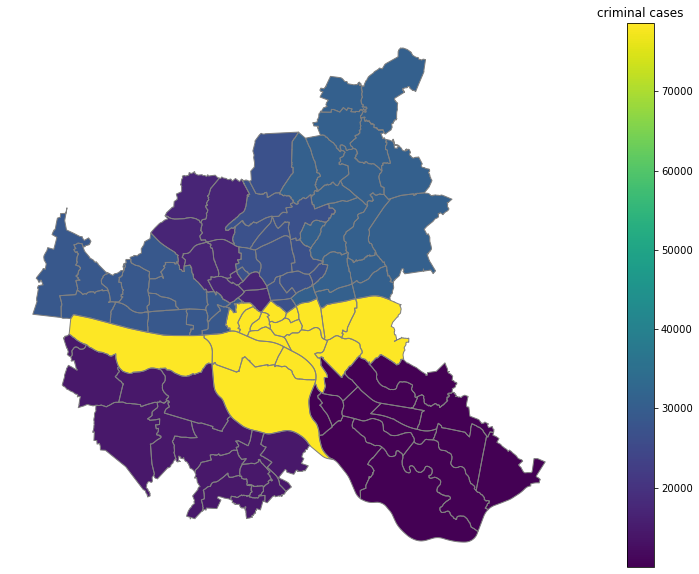

In [25]:
cogran_plot(attribute, source="choropleth", target="outlines")

### Weight values in the target data

In [26]:
cogran_plot(attribute="population", target="choropleth")

### Processed target data overlaid with source zones

In [27]:
cogran_plot(attribute, target="choropleth", source="outlines")

In [28]:
to_file(
    target_features,
    target_meta,
    attribute,
    "/tmp/attrw.gpkg",
    "GPKG",
)

INFO:root:Writing features to /tmp/attrw.gpkg...
INFO:root:Writing features... Done!


# Binary Dasymetric Weighting

We can supply a mask to cogran to eliminate regions that are known to have no causation with the values in the source data. For example we can mask the source zones of our population data to only be represented by actual residential living areas.

You can think of this as supplying a "NODATA" mask to the source data. The mask will be used to remove all spatial regions in the source that do not intersects with it (spatial intersection).

## Load source and target data

In [29]:
source_features, source_meta = get_features(
    "data/hamburg crime per bezirk.gpkg"
)

In [30]:
target_features, target_meta = get_features(
    "data/hamburg population per stadtteil.gpkg"
)

In [31]:
source_geometries = cogran.make_geometries(source_features)
target_geometries = cogran.make_geometries(target_features)

In [32]:
source_idx = cogran.generate_strtree(source_geometries)

## Load mask data

In [33]:
mask_features, mask_meta = get_features(
    "data/hamburg residential buildings with fake percentage of total population.gpkg"
)
# we won't use the attributes of this

In [34]:
mask_geometries = cogran.make_geometries(mask_features)
mask_idx = cogran.generate_strtree(mask_geometries)

## cogran

In [35]:
target_features = cogran.binary_dasymetric_weighting(
    source_features=source_features,
    source_geometries=source_geometries,
    source_idx=source_idx,
    target_features=target_features,
    target_geometries=target_geometries,
    mask_features=mask_features,
    mask_geometries=mask_geometries,
    mask_idx=mask_idx,
    attribute="criminal cases"
)

INFO:root:Running Binary Dasymetric Weighting...
INFO:root:Masking source features...


INFO:root:Dissolving masked features per source...
INFO:root:Dissolving masked features per source...
INFO:root:Dissolving masked features per source...
INFO:root:Dissolving masked features per source...
INFO:root:Dissolving masked features per source...
INFO:root:Dissolving masked features per source...
INFO:root:Dissolving masked features per source...
INFO:root:Generating masked source geometries...


INFO:root:Generating spatial index for masked source geometries...
INFO:root:Processing target features...


INFO:root:Pycnophylactic property: 206689 (source) is within 0.001% of 206689.00000000047 (target).


### Source data overlaid with target zones

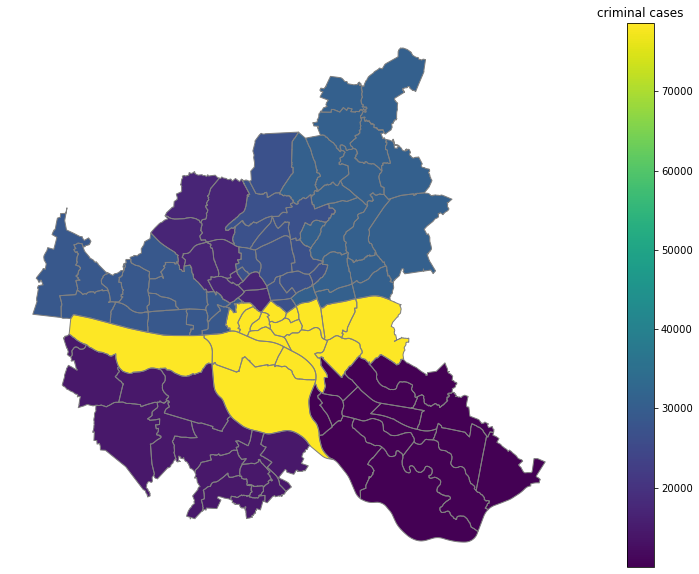

In [36]:
cogran_plot(source="choropleth", target="outlines", attribute="criminal cases")

### Processed target data overlaid with source zones

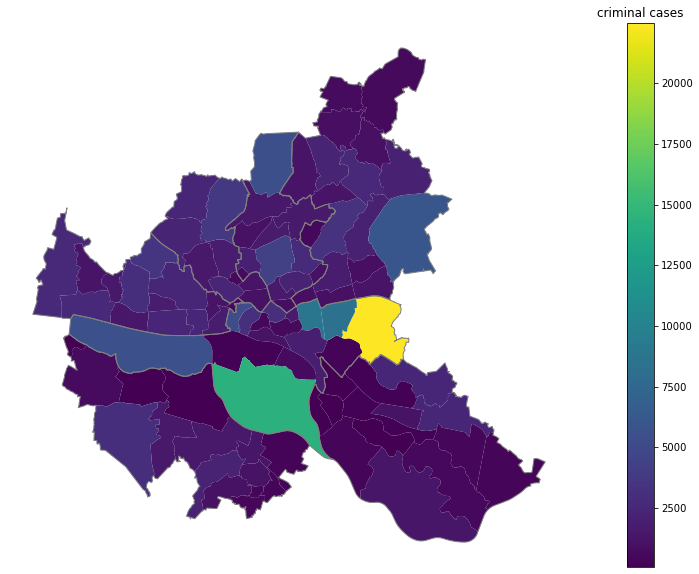

In [37]:
cogran_plot(target="choropleth", source="outlines", attribute="criminal cases")

In [38]:
to_file(
    target_features,
    target_meta,
    "criminal cases",
    "/tmp/bdw.gpkg",
    "GPKG",
)

INFO:root:Writing features to /tmp/bdw.gpkg...
INFO:root:Writing features... Done!


# N-Class Dasymetric Weighting

N-class dasymetric allows the use of "control" zones to be used as weights. Each of these zones can hold a percentual value of what fraction of the total of the phenomena is represented by the zone. For example for a dataset of buildings of a city, where both the total number of inhabitants as well as the number of inhabitants per building is known, each building would have a value like 0.00123 if there were 0.00123 of the total number of inhabitants living in it. The total sum of these fractional values will then be taken into account when calculating the new values for the target zones.

The name "N-Class" refers to the many different individual values the control zones can take. I think.

This is not very elegant but all we can do for now (https://gitlab.com/g2lab/cogran-python/issues/47).

Our example dataset has an attribute field `fake_percentage` which holds a made-up percentage of total inhabitants who live within each feature's spatial region.

This was calculated using:

```
total_population = 1841179  # hamburg
total_area = 35370831  # groupstats plugin... of residential buildings in hamburg

area_per_person = total_area / total_population
print(f"Each person takes ~{area_per_person}")

# example calculation per building
area = 200
people = area / area_per_person
print(f"{people} people fit into an area of {area}")
percentage = people / total_population * 100
print(f"That's {percentage} % of the total population")
```

or in QGIS:


```
with_variable(
	'total_population',
	1841179,
	
	with_variable(
		'area_per_person',
		35370831/@total_population,

		with_variable(
			'people',
			($area / @area_per_person),

			@people / @total_population * 100
		)
	)
)
```

## Load source and target data

In [39]:
source_features, source_meta = get_features(
    "data/hamburg crime per bezirk.gpkg"
)

In [40]:
target_features, target_meta = get_features(
    "data/hamburg population per stadtteil.gpkg"
)

In [41]:
source_geometries = cogran.make_geometries(source_features)
target_geometries = cogran.make_geometries(target_features)

In [42]:
source_idx = cogran.generate_strtree(source_geometries)

## Load mask data

In [43]:
mask_features, mask_meta = get_features(
    "data/hamburg residential buildings with fake percentage of total population.gpkg"
)

In [44]:
mask_geometries = cogran.make_geometries(mask_features)
mask_idx = cogran.generate_strtree(mask_geometries)

## cogran

In [45]:
target_features = cogran.nclass_dasymetric_weighting(
    source_features=source_features,
    source_geometries=source_geometries,
    source_idx=source_idx,
    target_features=target_features,
    target_geometries=target_geometries,
    mask_features=mask_features,
    mask_geometries=mask_geometries,
    mask_idx=mask_idx,
    attribute="criminal cases",
    weight="fake percentage of total population"
)

INFO:root:Running N-Class Dasymetric Weighting...
INFO:root:Calculating mask weight per intersection with source feature...


INFO:root:Overlaying source and mask features & calculating weight per fragment...


INFO:root:Generating masked source geometries...


INFO:root:Generating spatial index for masked source geometries...
INFO:root:Processing target features...


INFO:root:Pycnophylactic property: 206689 (source) is within 0.001% of 206699.3968873259 (target).


### Source data overlaid with target zones

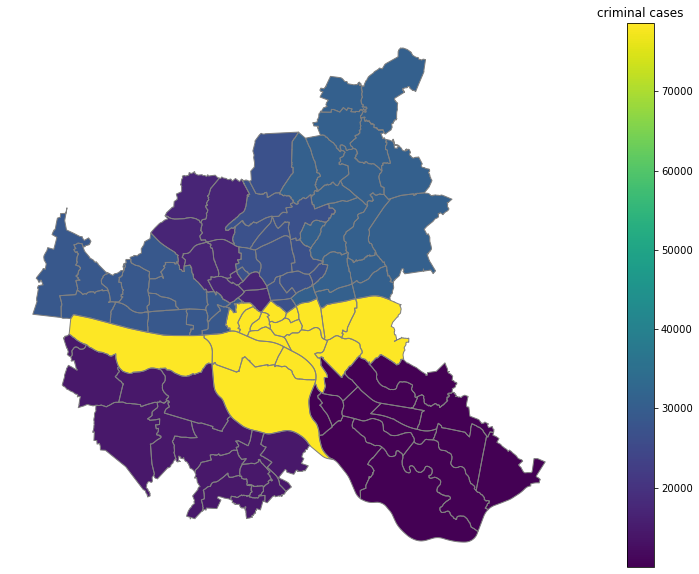

In [46]:
cogran_plot(attribute, source="choropleth", target="outlines")

### Processed target data overlaid with source zones

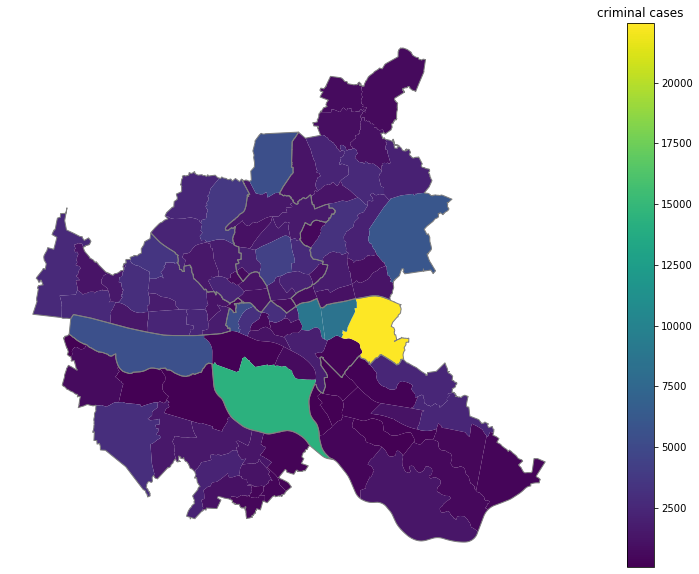

In [47]:
cogran_plot(attribute, target="choropleth", source="outlines")

In [48]:
to_file(
    target_features,
    target_meta,
    "criminal cases",
    "/tmp/ndw.gpkg",
    "GPKG",
)

INFO:root:Writing features to /tmp/ndw.gpkg...
INFO:root:Writing features... Done!
